<a href="https://colab.research.google.com/github/eborin/SSL-course/blob/main/14_minerva_CPC-UCI-latent_space_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/SSL-course/blob/main/14_minerva_CPC-UCI-latent_space_vis.ipynb)

# Visualizing Latent Spaces with Pretrained Models and t-SNE

In this notebook, we explore how pretrained backbones organize information by visualizing their latent spaces.

Using data from a target task and backbones pretrained in previous tutorials, we extract feature representations and apply t-SNE to project them into a 2D space.
This visualization helps us better understand the structure of the learned features and how the models internally separate different classes.

## 1. Introduction

### 1.1 Objective

The objective of this tutorial is to help students understand how to assess the performance of pretrained neural network backbones by using dimensionality reduction techniques to inspect the latent space produced by these backbones with samples from a target dataset.

First, we will extract feature embeddings from a target task dataset using both pretrained and randomly initialized backbones.
We will then apply t-SNE to reduce these high-dimensional representations into two dimensions for visualization.

By analyzing the resulting 2D plots, we aim to gain insights into how different classes are organized in the feature space, how effectively pretrained models separate categories, and how the latent structure reflects the model’s learned representations.

Key Points Covered:

* Extract features from pretrained and random backbones.

* Apply t-SNE to project high-dimensional representations into 2D.

* Visualize and interpret how models internally organize and differentiate between samples.


### 1.2 What we will cover

We will begin by setting up the target dataset.
Next, we will write code to load backbones pretrained in previous tutorials.
Finally, we will extract features and visualize target dataset samples on 2D charts using t-SNE.

| **Topic** | **Contents** |
| ----- | ----- |
| [**2. Basic Setup**](#sec_2) | Import the necessary modules (PyTorch, Torchvision, and PyTorch Lightning), and define the key variables that control the evaluation process.  |
| [**3. Setting Up the Dataset**](#sec_3) | Prepare the target dataset. |
| [**4. Loading Pretrained Backbones**](#sec_4) | Implement code to load backbones pretrained in earlier tutorials. |
| [**5. Evaluating the Backbones**](#sec_5) | Extract features and plot target dataset samples on 2D charts using t-SNE. |


### 1.3 Where can you get help?

In addition to discussing with your colleagues or the course professor, you might also consider:

* Minerva: check the [Minerva docs](https://discovery-unicamp.github.io/Minerva/).

* Lightning: check the [Lightning documentation](https://lightning.ai/docs/overview/getting-started) and research or post Lightning related question on the [PyTorch Lightning forum](https://lightning.ai/forums/).

* PyTorch: check the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and research or post PyTorch related question on the [PyTorch developer forums](https://discuss.pytorch.org/).

## <a id="sec_2">2. Basic setup</a>

### 2.1 Setting the main variables

* `max_number_of_samples_per_class`: Defines the number of samples per class that will be plotted. Samples are selected randomly.
This parameter can be adjusted to reduce the time it takes to plot each chart.

In [1]:
## General configuration variables

# Number of samples per class to plot
max_number_of_samples_per_class = 200

### 2.2 Installing Lightining and Minerva modules

The code below attempts to import Minerva and installs it if it is not already available.
Since Minerva depends on the Lightning module, Lightning will also be installed automatically when Minerva is installed.

In [2]:
try:
    import minerva
except:
    try:
        #Try to install it and import again
        print("[INFO]: Could not import the minerva module. Trying to install it!")
        !pip install -q minerva-ml
        import minerva
        print("[INFO]: It looks like minerva was successfully imported!")
    except:
        raise Exception("[ERROR] Couldn't find the minerva module ... \n" +
                        "Please, install it before running the notebook.\n"+
                        "You might want to install the modules listed at requirements.txt\n" +
                        "To do so, run: \"pip install -r requirements.txt\"")

### 2.3 Importing basic modules

In [3]:
# Import PyTorch
import torch

# Import torchvision
import torchvision

# Import lightning
import lightning

# Import minerva
import minerva

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"Lightning version: {lightning.__version__}")
#print(f"Minerva version: {M.__version__}") ## TODO

# Import matplotlib for visualization
import matplotlib.pyplot as plt

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
Lightning version: 2.5.1


## <a id="sec_3">3. Setting Up the Dataset</a>

### 3.1 Download and instantiate the test dataset

As in tutorial `13_minerva_CPC-UCI-backbone_pretrain.ipynb`, we will download a version of the UCI-HAR dataset made available from my website.
The following code block downloads and unpacks the dataset into the `data/uci_pretrain` folder. 

In [4]:
import os
filename = 'uci_pretrain.zip'

if not os.path.exists(filename):
    # Download the zip file with checkpoints
    import urllib.request
    url = 'https://www.ic.unicamp.br/~edson/disciplinas/mo810/2025-1s/uci_pretrain.zip'
    urllib.request.urlretrieve(url, filename)

if not os.path.exists("data/uci_pretrain/"):
    # Unzip the checkpoint file
    import zipfile
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

In [5]:
from data.uci_pretrain.dataset import UCIHARDataset

# Parameters
dataset_path = "./data/uci_pretrain/"
window_sz = 60
window_stride = 30 # 50% of window overlap

test_dataset = UCIHARDataset(
            dataset_path=dataset_path,
            splits="test",
            window_sz=window_sz,
            window_stride=window_stride,
            transpose_data=True)

class_names = test_dataset.classes

print(f"Class names: {class_names}")

print(test_dataset)

Class names: ['sit', 'stand', 'walk', 'upstairs', 'downstairs']
UCIHARDataset(paths=['./data/uci_pretrain/'], features.shape=(1379, 6, 60), labels.shape=(1379,), splits=['test'], window sz=60, window stride=30)


### 3.2 Filtering the dataset

In [6]:
from torch.utils.data import Subset
import random

def sample_dataset(dataset, max_number_of_samples_per_class):
    indices = {}

    # Group samples indices by label.
    for i in range(len(dataset)):
        _, label = dataset[i]
        if not label in indices: indices[label] = []
        indices[label].append(i)

    # For each label, select a subset of at most max_number_of_samples_per_class samples.
    selected_indices = []
    for k, v in indices.items():
        selected_indices.extend(v[:min(max_number_of_samples_per_class, len(v))])

    # Shuffle the indices list
    random.shuffle(selected_indices)

    return Subset(dataset, selected_indices)

In [7]:
filtered_dataset = sample_dataset(test_dataset, max_number_of_samples_per_class)


## <a id="sec_4">4. Loading Pretrained Backbones</a>

This section contains code to load pretrained backbones.


### 4.1 Loading a pretrained backbone

The pretrained backbone weights are stored in a checkpoint file, along with the projection head weights and other information from the Minerva CPC model.

To load these weights, you must first instantiate an equivalent CPC model—using the same backbone and projection head architecture—and then call the `load_from_checkpoint()` method.

The code below includes functions to generate backbones and projection heads that are structurally identical to those used when the checkpoints were originally created.

In [8]:
from minerva.models.nets.cpc_networks import Convolutional1DEncoder, HARCPCAutoregressive, Genc_Gar

def build_encoder():
    # Instantiate a 1D convolutional encoder for multi-channel time series input
    return Convolutional1DEncoder(input_size=6, kernel_size=3)

def build_autoregressor():
    # Create a unidirectional GRU-based autoregressive model for sequence modeling
    return HARCPCAutoregressive(
        input_size=128, hidden_size=256, batch_first=True, bidirectional=False
    )

def generate_backbone():
    """
    Return a Genc_Gar backbone (encoder + autoregressor) without pretrained weights.
    Used for training models from scratch on downstream tasks.
    """
    g_enc = build_encoder()
    g_ar = build_autoregressor()
    return Genc_Gar(g_enc=g_enc, g_ar=g_ar)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The function below instantiates a Minerva `CPC` model using the same backbone and projection head architectures as in the previous tutorial.
It then loads the weights from a checkpoint file and returns the model's backbone.

**Note:** If `use_checkpoint=False`, the model is initialized randomly, that is, from scratch.

In [9]:
from minerva.models.ssl.cpc import CPC

def load_pretrained_backbone(ckpt_filename=None, use_checkpoint=True):
    g_enc = build_encoder()
    g_ar = build_autoregressor()

    if use_checkpoint and ckpt_filename is not None:
        pretext_model = CPC.load_from_checkpoint(
            ckpt_filename,
            g_enc=g_enc,
            g_ar=g_ar,
            prediction_head_in_channels=256,
            prediction_head_out_channels=128
        )
        return pretext_model.g_enc, pretext_model.g_ar

    return g_enc, g_ar

#### **Note on checkpointing**

The code above uses the Lightning `load_from_checkpoint()` method to restore model weights from a checkpoint.
To do this, we must reconstruct the model architecture exactly as it was when the checkpoint was created—which is why we needed to define both the backbone and the projection head.

Alternatively, you could load the checkpoint using `torch.load()` to retrieve its contents as a dictionary, and then manually extract the backbone weights.
More information on extracting specific components, such as the backbone, from a PyTorch Lightning checkpoint is available in the [Lightning documentation](https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html#nn-module-from-checkpoint).

Lastly, it is worth noting that Lightning provides an [experimental API for customizing the checkpointing process](https://lightning.ai/docs/pytorch/1.6.3/common/checkpointing.html#customize-checkpointing).
This API could be used during SimCLR pretraining to save only the backbone weights, streamlining the process for downstream tasks.

## <a id="sec_5">5. Evaluating the backbones</a>

Now, we will load pretrained backbones and evaluate them by examining how they organize the test dataset samples in the latent space.
To do this, we will extract features from the test samples using the backbone and apply t-SNE to project them into a 2D space.

### 5.1 Extracting features

First, let's implement a function to extract the features of the samples using a given backbone.

For each sample in the dataloader, this function encodes the original features using the backbone and stores the features on an numpy array.

In [10]:
import numpy as np
import torch

def extract_features(backbone, dataset):
    backbone.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for original_features, label in dataset:
            # Ensure the original_features are a tensor
            if isinstance(original_features, np.ndarray):
                original_features = torch.tensor(original_features, dtype=torch.float32)

            # Send the features to the computing device
            device = next(backbone.parameters()).device
            original_features = original_features.to(device)

            # Ensure the data has a batch dimension (1,C,T)
            if original_features.ndim == 2:
                original_features = original_features.unsqueeze(0)

            # Extract the features Extrai as features com o backbone
            features = backbone(original_features)
            features_list.append(features.squeeze(0).cpu().numpy())
            labels_list.append(label)

    # Return two numpy arrays, one with the dataset features and another with the dataset labels.
    return np.stack(features_list), np.stack(labels_list)


### 5.2 Plotting Samples on 2D chart

In [11]:
import plotly.express as px

# Function to plot data
def plot_samples_plotly(features, labels, title):
    y_str = [class_names[i.item()] for i in labels]
    samples_indices = list(range(len(y_str)))
    fig = px.scatter(x=features[:,0], y=features[:,1],
                    color=y_str,
                    hover_name=y_str,
                    hover_data={"Image index": samples_indices})
    fig.update_layout(title=title)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.show()

### 5.3 Downloading Minerva CPC checkpoints

We will use checkpoints generated by CPC in the tutorial `13_minerva_CPC-UCI-backbone_pretrain.ipynb`.

If you did not save your own checkpoints, you can download a pre-generated checkpoints that I have made available.
For convenience, the code below will automatically download and extract these checkpoints.

In [ ]:
import os
filename = '13_minerva_CPC_UCI_backbone_pretraining-1-20.zip'

if not os.path.exists(filename):
    # Download the zip file with checkpoints
    import urllib.request
    url = 'https://www.ic.unicamp.br/~edson/disciplinas/mo810/2025-1s/13_minerva_CPC_UCI_backbone_pretraining-1-20.zip'
    urllib.request.urlretrieve(url, filename)

if not os.path.exists("logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/"):
    # Unzip the checkpoint file
    import zipfile
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

### 5.4 Load the Backbones

Now, let's load the pretrained backbones. We will also add two extra backbones, one that was not trained and another that was pretrained with ImageNet.

In [ ]:
import lightning
import glob


# Set seed for reproducibility
lightning.seed_everything(42)

# Lista de backbones para avaliação
backbones = []

# Search for the checkpoints on the following folder
cpc_ckpt_files = glob.glob("logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/epoch=*.ckpt")

# For each checkpoint file.
for i, ckpt_filename in enumerate(cpc_ckpt_files):
    print(f"==== {len(backbones):3d} {ckpt_filename} ====")

    g_enc, g_ar = load_pretrained_backbone(ckpt_filename)
    backbone_cpc = Genc_Gar(g_enc=g_enc, g_ar=g_ar)

    # Extract basename and epoch info from checkpoint path
    info = ckpt_filename.split("/") 
    checkpoint_filename = info[6]
    epoch_info = checkpoint_filename.split("-")[0]
    epoch_number = int(epoch_info.split("=")[1])

    backbones.append({
        "basename": f"CPC-{epoch_number}",
        "epoch number": epoch_number,  
        "ckpt_filename": ckpt_filename,
        "backbone": backbone_cpc
    })

# -- Random Backbone (from scratch) --
backbone_from_scratch = generate_backbone()
backbones.append({
    "basename": "Random",
    "epoch number": 0,
    "ckpt_filename": "None",
    "backbone": backbone_from_scratch
})

# Sort configurations according to checkpoint epoch number
backbones = sorted(backbones, key=lambda i: i["epoch number"])

# Print dos backbones carregados
print("List of backbones:", [i["basename"] for i in backbones])


Seed set to 42


====   0 logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/epoch=3-step=304-v1.ckpt ====
====   1 logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/epoch=7-step=608-v1.ckpt ====
====   2 logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/epoch=11-step=912-v1.ckpt ====
====   3 logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/epoch=15-step=1216-v1.ckpt ====
====   4 logs/13_minerva_CPC_UCI/Pretext/CPC-conv-gru/version_0/checkpoints/epoch=19-step=1520.ckpt ====
List of backbones: ['Random', 'CPC-3', 'CPC-7', 'CPC-11', 'CPC-15', 'CPC-19']


### 5.5 Evaluate the Backbones

Before we begin, let's configure the Plotly renderer.
To display interactive charts directly in your notebook, set `pio.renderers.default` to `"jupyterlab"` or `"vscode"`, depending on your environment.
You can view all available renderers on your system by printing the `pio.renderers` variable.

> **Hint**: Interactive Plotly charts let you explore the data by hovering over sample points to reveal detailed information.

In [14]:
# Configure the plotly renderer to use jupyterlab - you might print the
# contents of the pio.renderers variable to check for other available
# renderers (examples include: vscode, png, jpeg, pdf, ...)
import plotly.io as pio
pio.renderers.default = "png"
#pio.renderers.default = "colab"
#pio.renderers.default = "vscode"
#print(pio.renderers)
#pio.renderers.default = "jupyterlab"

Next, for each backbone, we will encode the features of the filtered dataset, apply t-SNE to reduce the feature dimensionality to two dimensions, and finally plot the resulting samples on a 2D chart.

** Backbone Random **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


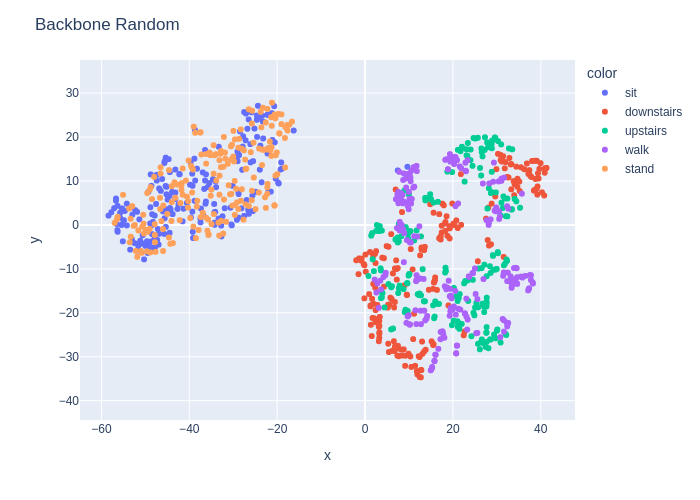

** Backbone CPC-3 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


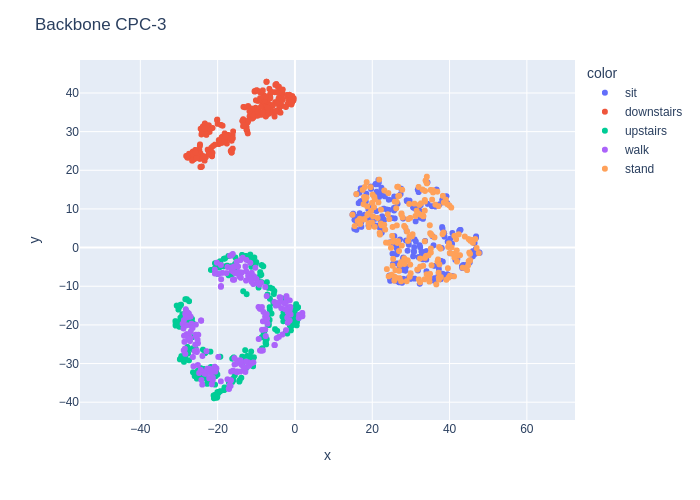

** Backbone CPC-7 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


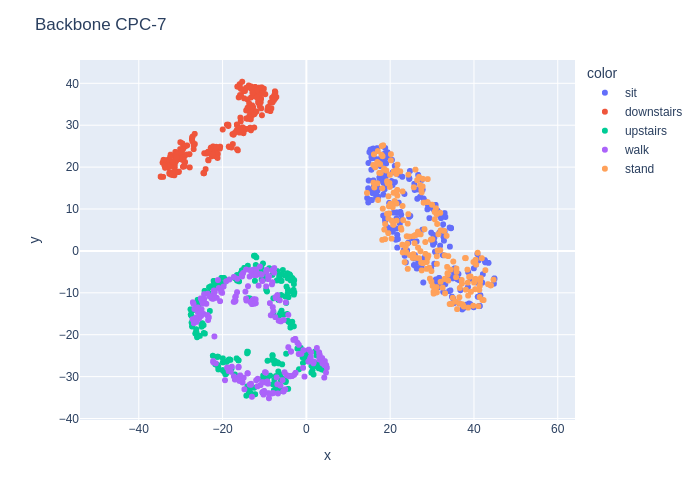

** Backbone CPC-11 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


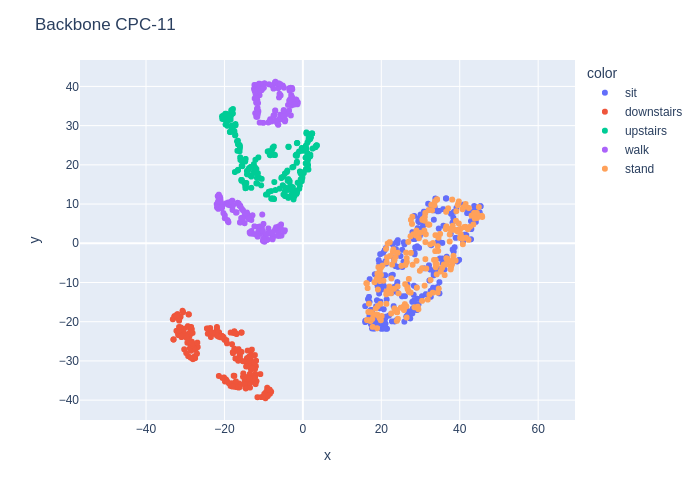

** Backbone CPC-15 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


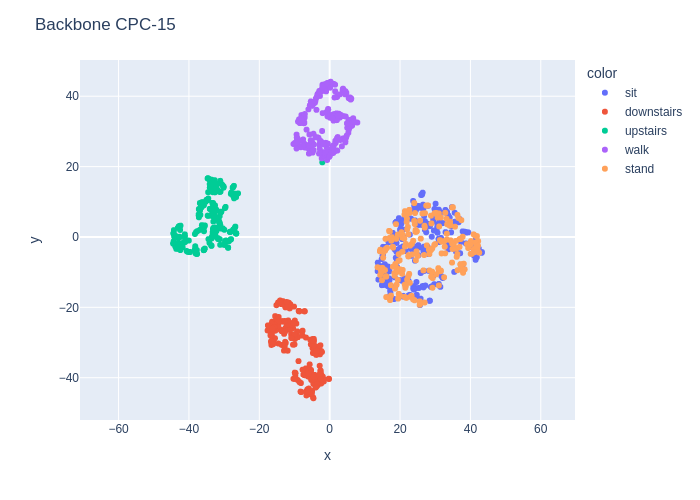

** Backbone CPC-19 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


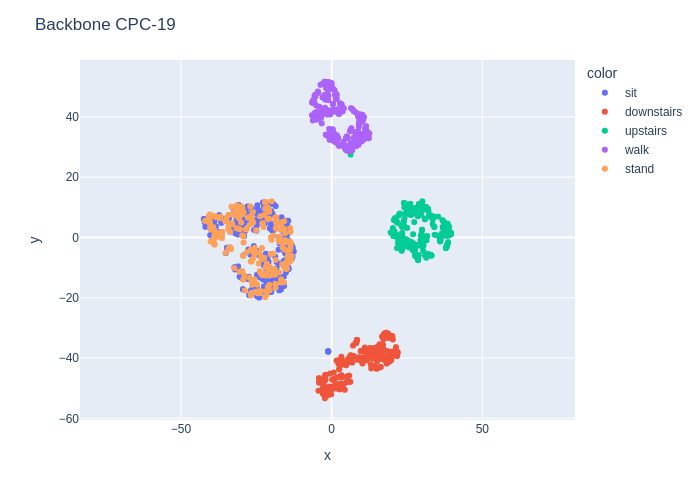

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2) # , perplexity=100)

for backbone_info in backbones:
    basename = backbone_info["basename"]
    print(f"** Backbone {basename} **")

    print("- Extracting features...", end="")
    backbone = backbone_info["backbone"]
    learned_features, labels = extract_features(backbone, filtered_dataset)

    print("[Done]\n- Projecting with t-SNE...", end="")
    tsne_features = tsne.fit_transform(learned_features)

    print("[Done]\n- Plotting the chart.")
    plot_samples_plotly(tsne_features, labels, f"Backbone {basename}")

As observed in the charts, backbones trained for more epochs (e.g., CPC-19) demonstrate a stronger ability to cluster samples according to their activity classes.
With just 15 epochs of CPC training (CPC-15), the backbone is already capable of forming distinct clusters for the downstairs, upstairs, and walk classes.
Samples from the sit and stand classes tend to cluster together in the latent space; however, they remain well-separated from the other classes and are not misclassified.